# Active Kriging-Monte Carlo Simulation Example 1
Author: Mohit S. Chauhan Date: Aug 04, 2019

In this example, Stratified sampling is used to generate samples from Uniform distribution and new samples are generated adaptively, using U-function as the learning criteria .

Import the necessary libraries. Here we import standard libraries such as numpy, matplotlib and other necessary library for plots, but also need to import the MCS, STS and AKMCS class from UQpy.

In [1]:
from UQpy.SampleMethods import MCS
from UQpy.SampleMethods import STS
from UQpy.SampleMethods import AKMCS
from UQpy.Surrogates import Krig
from UQpy.RunModel import RunModel
from series_system import series
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import Matern
import numpy as np
import scipy.stats as sp
import time

Using UQpy STS class to generate samples for two random variables, which are normally distributed with mean 0 and variance 1.

In [2]:
np.random.seed(2)
x = STS(dist_name=['Normal']*2, dist_params=[[0, 3], [0, 3]], sts_design=[4, 4])


UQpy: Successful execution of STS design..


RunModel class is used to define an object to evaluate the model at sample points.

In [3]:
rmodel = RunModel(model_script='series_system.py')


Krig class defines an object to generate an surrogate model for a given set of data.

In [4]:
K = Krig(reg_model='Linear', corr_model='Exponential', n_opt=5, dimension=2)

AKMCS class is used to generate new sample using 'U-function' as active learning function.

In [5]:
# OPTIONS: 'U', 'EFF', 'Weighted-U'
learning_function = 'U'

In [6]:
%%capture
start_time = time.time()
a = AKMCS(run_model_object=rmodel, sample_object=x, krig_object=K, nlearn=10**3, n_add=1, lf=learning_function, min_cov=0.05, max_p=sp.norm.pdf(0, 0, 4)**2)
a.run(nsamples=60)
elapsed_time = time.time() - start_time

In [7]:
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print('Time: ', elapsed_time)
print('Function evaluation: ', len(a.run_model_object.qoi_list))
print('Probability of failure: ', a.pf[-1], '  ', 'Covariance: ', a.cov_pf[-1])

Time:  2.3701841831207275
Function evaluation:  60
Probability of failure:  0.4005905511811024    Covariance:  0.03837643141953822


This figure shows the location of new samples generated using active learning function.

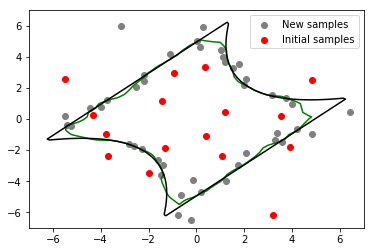

In [8]:
num = 50
x1 = np.linspace(-7, 7, num)
x2 = np.linspace(-7, 7, num)
x1v, x2v = np.meshgrid(x1, x2)
y = np.zeros([num, num])
y_act = np.zeros([num, num])
mse = np.zeros([num, num])
for i in range(num):
    for j in range(num):
        xa = x.distribution[0].cdf(np.atleast_2d(x1v[i, j]), x.dist_params[0])
        ya = x.distribution[1].cdf(np.atleast_2d(x2v[i, j]), x.dist_params[1])
        y[i, j] = a.krig_model(np.hstack([xa, ya]))
        y_act[i, j] = series(np.array([x1v[i, j], x2v[i, j]]))

fig, ax = plt.subplots()
# ax = plt.axes(projection='3d')
# Plot for estimated values
kr = ax.contour(x1v, x2v, y, levels=[0], colors='Green')
# kr.cmap.set_over('green')
kr_a = ax.contour(x1v, x2v, y_act, levels=[0], colors='Black')


# Plot for scattered data
nd = np.prod(x.sts_design)
ID1 = ax.scatter(a.sample_object.samples[nd:, 0], a.sample_object.samples[nd:, 1], color='Grey', label='New samples')
ID = ax.scatter(x.samples[:nd, 0], x.samples[:nd, 1], color='Red', label='Initial samples')
plt.legend(handles=[ID1, ID])
plt.show()

Probability of failure and covariance is estimated using Monte Carlo Simulation.

In [9]:
start_time = time.time()

# Code
b = MCS(dist_name=x.dist_name, dist_params=x.dist_params, nsamples=10**5)
r1model = RunModel(model_script='series_system.py')
r1model.run(samples=b.samples)
gx = np.array(r1model.qoi_list)
pf_mcs = np.sum(np.array(gx) < 0)/b.nsamples
cov_pf_mcs = np.sqrt((1 - pf_mcs)/(pf_mcs * b.nsamples))

elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

'00:00:03'

Results from Monte Carlo Simulation.

In [10]:
print('Time: ', elapsed_time)
print('Function evaluation: ', b.nsamples)
print('Probability of failure: ', pf_mcs, '  ', 'Covariance: ', cov_pf_mcs)

Time:  3.3528120517730713
Function evaluation:  100000
Probability of failure:  0.41706    Covariance:  0.0037386314831891984
